# Encapsulating custom code into Gym environments: A turning controller

**Author:** Victor Alfred Stimpfling, Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified for simplicity and restructured for display in a notebook format. A more complete and better structured implementation can be found on the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary:** In this tutorial, we will demonstrate how one can build controllers at different levels of abstraction by implementing Gym environments encoding variable amounts of preprogrammed computation. As an example, we will refactor the code we wrote in the [hybrid controller tutorial](https://neuromechfly.org/tutorials/hybrid_controller.html#building-a-hybrid-controller) and implement turning by asymmetrically modulating the amplitude and frequency of CPGs.

## Gym environments and MDP

So far, we have interacted with the `NeuroMechFly` class which implements the [Gym interface](https://gymnasium.farama.org/): it has an action space (input given by the user), an observation space (output returned to the user), a `.step(...)` method, a `.reset(...)` method, and a `.render(...)` method. The action and observation spaces of `NeuroMechFly` are as follows:

- Action space:
    - "joints": 42-dimensional real vector ∈ [0, 2π] indicating joint angles (in default position control mode)
    - "adhesion": 6-dimensional integer vector ∈ {0, 1} indicating whether adhesion is turned on for each leg
- Observation space:
    - "joints": shape (3, 42) real array indicating joint angles (0th row), velocities (1st row), and torques (2nd row)
    - "fly": shape (4, 3) real array indicating fly xyz positions (0th row), xyz velocities (1st row), yaw-pitch-roll angles (2nd row), and yaw-pitch-roll velocities (3rd row)
    - "contact_forces": shape (N, 3) - contact forces, in xyz directions, of the N segments defined in `contact_sensor_placements`
    - "end_effectors": shape (6, 3) - xyz positions of the six legs in the order of LF, LM LH, RF, RM, RH
    - "fly_orientation": shape (3,) - unit vector indicating the fly's heading orientation


The FlyGym package is designed to be expandable: the user can implement their own Gym environments with different action and observation spaces and implement different logics (e.g. preprogrammed premotor computation and sensory processing). This is illustrated in the figure below:

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/mdp.png?raw=true" alt="rule_based" width="500"/>

In the hybrid controller that [we have implemented](https://neuromechfly.org/tutorials/hybrid_controller.html#building-a-hybrid-controller), the underlying CPG network and the correction mechanisms can be considered the user-defined premotor computation (purple). The whole controller can be considered the box indicating the Markov Decision Process (MDP). Here, we will add a 2D descending signal that encodes turning. The action and observation spaces of our MDP "box" are as follows:

- Action space: a 2-dimensional real vector describing the velocity on each side of the body. Although in principle the range of the amplitude is unrestricted, its absolute value shouldn't go far beyond 1 because otherwise the steps become very unrealistic.
- Observation space: same as above (no sensory processing logic indicated in cyan)

## Approach for turning

We will use a 2-dimensional representation of descending signals $[\delta_L, \delta_R] \in \mathbb{R}^2$ to modulate the amplitude and direction of the leg CPGs on each side of the body. Specifically, we will modulate the intrinsic amplitude $R'$ and intrinsic frequency $\nu'$ on each side by:

$$
R'(\delta) = |\delta|
$$

$$
\nu_i'(\delta) = \begin{cases}
\nu_i   & \text{if } \delta>0\\
-\nu_i  & \text{otherwise}
\end{cases}
$$

In other words, the magnitude of the descending signal controls the amplitude of stepping (as a gain applied to the originally recorded step size); the sign of the descending signal controls the direction of stepping. Of course, this is a very simplified model of turning. Perhaps the most unrealistic aspect of it is that it assumes that the step size spans linearly from 0 to 1x the recorded "real" step size. This is an area for future improvement.

## Implementing the `HybridTurningController` class

A key idea of the Gym interface is that it allows users to encapsulate the control logic in a Gym environment (a MDP), and expose only the input and output (action and observation) to the controller. This is achieved using [class inheritance](https://www.w3schools.com/python/python_inheritance.asp) in Python. Briefly, it allows a new class (subclass or child class) to inherit attributes and methods from an existing class (base class or parent class), enabling code reuse and the creation of hierarchical relationships between classes. Refer to the tutorial linked above to familiarize yourself with this concept.

All Gym environments inherit from the `gymnasium.Env` class. You can refer to [the API reference of this class](https://gymnasium.farama.org/api/env/#gymnasium-env) for a full specification, or [this page](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/) for a tutorial on how to make your own custom environment. The `NeuroMechFly` class we have used so far inherits from it and therefore complies with its specifications. Here, we will build a `HybridTurningController` class that inherits from `NeuroMechFly` to provide a simplified interface to control turning via a 2D input space, which can be interpreted as a descending code.

First, let's do the necessary imports and define the default parameter as before:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from gymnasium import spaces
from gymnasium.utils.env_checker import check_env

from flygym import Fly, Camera, SingleFlySimulation
from flygym.examples.common import PreprogrammedSteps
from flygym.examples.locomotion.cpg_controller import CPGNetwork


_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

_default_correction_vectors = {
    # "leg pos": (Coxa, Coxa_roll, Coxa_yaw, Femur, Femur_roll, Tibia, Tarsus1)
    # unit: radian
    "F": np.array([-0.03, 0, 0, -0.03, 0, 0.03, 0.03]),
    "M": np.array([-0.015, 0.001, 0.025, -0.02, 0, -0.02, 0.0]),
    "H": np.array([0, 0, 0, -0.02, 0, 0.01, -0.02]),
}

_default_correction_rates = {"retraction": (800, 700), "stumbling": (2200, 1800)}

Now, we will define the `__init__` method of our `HybridTurningNMF` class. The [complete, functional class definition](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/examples/hybrid_turning_controller.py) can be found on our GitHub repository. You can import it with `from flygym.examples.turning_controller import HybridTurningNMF`.

We start with initializing the parent class by calling `super().__init__(...)`. This basically calls the `__init__` logic of the parent `NeuroMechFly` class using the specified parameters:

```Python
class HybridTurningNMF(NeuroMechFly):
    def __init__(
        self,
        fly: Fly,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        stumble_segments=("Tibia", "Tarsus1", "Tarsus2"),
        stumbling_force_threshold=-1,
        correction_vectors=_default_correction_vectors,
        correction_rates=_default_correction_rates,
        amplitude_range=(-0.5, 1.5),
        draw_corrections=False,
        max_increment=80/1e-4,
        retraction_persistance_duration=20/1e-4,
        retraction_persistance_initiation_threshold=20/1e-4,
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        ...
```

We can save the arguments as class attributes:

```Python
        ...
        
        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.stumble_segments = stumble_segments
        self.stumbling_force_threshold = stumbling_force_threshold
        self.correction_vectors = correction_vectors
        self.correction_rates = correction_rates
        self.amplitude_range = amplitude_range
        self.draw_corrections = draw_corrections
        self.max_increment = max_increment * self.timestep
        self.retraction_persistance_duration = retraction_persistance_duration * self.timestep
        self.retraction_persistance_initiation_threshold = (
            retraction_persistance_initiation_threshold * self.timestep
        )
        self.retraction_persistance_counter = np.zeros(6)
        # Define the joints that need to be inverted to
        # mirror actions from left to right 
        self.right_leg_inversion = [1, -1, -1, 1, -1, 1, 1]

        ...
```

Next, we need to override the action space of `NeuroMechFly`. This is done by defining a new Gym space object. Gym provides an [interface for various space types](https://gymnasium.farama.org/api/spaces/). An non-exhaustive list includes `Box` for a possibly-bounded box in $\mathbb{R}^n$, `Discrete` for a finite set of options, `Text` for text, and various [composite spaces](https://gymnasium.farama.org/api/spaces/composite/) such as `Dict`, `Tuple`, `Sequence`, `Graph`. Here, we will define the descending space as a `Box` space. We won't change the observation space definition since we will return `NeuroMechFly`'s observation as is:

```Python
        ...

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        ...
```

Then, we will initialize the CPG network that we defined [in the CPG tutorial](https://neuromechfly.org/tutorials/cpg_controller.html):

```Python
        ...
        
        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)

        ...
```

We will then initialize variables tracking the amount of retraction and stumbling correction as we did in the [hybrid controller tutorial](https://neuromechfly.org/tutorials/hybrid_controller.html):

```Python
        ...

        # Initialize variables tracking the correction amount
        self.retraction_correction = np.zeros(6)
        self.stumbling_correction = np.zeros(6)

        ...
```

Finally, we will find the contact sensors for stumbling detection as we did before. This time, we define it as a method of our new class:

```Python
   def _find_stumbling_sensor_indices(self):
        """Find the indices of the sensors that are used for stumbling detection."""
        stumbling_sensors = {leg: [] for leg in self.preprogrammed_steps.legs}
        for i, sensor_name in enumerate(self.fly.contact_sensor_placements):
            leg = sensor_name.split("/")[1][:2]  # sensor_name: e.g. "Animat/LFTarsus1"
            segment = sensor_name.split("/")[1][2:]
            if segment in self.stumble_segments:
                stumbling_sensors[leg].append(i)
        stumbling_sensors = {k: np.array(v) for k, v in stumbling_sensors.items()}
        if any(
            v.size != len(self.stumble_segments) for v in stumbling_sensors.values()
        ):
            raise RuntimeError(
                "Contact detection must be enabled for all tibia, tarsus1, and tarsus2 "
                "segments for stumbling detection."
            )
        return stumbling_sensors
```

... and we can all it in `__init__`. This concludes the definition of our `__init__` method:

```Python
        ...
        
        # Find stumbling sensors
        self.stumbling_sensors = self._find_stumbling_sensor_indices()
```

Next, we shall define the `reset` method of our `HybridTurningController` class. This involves resetting the underlying `NeuroMechFly` simulation — as before, we will call `super().reset(...)` to drop in the reset method of the parent class. Then, we will reset the CPG network and the stumbling amounts. Note that the `**kwargs` argument is required to fully comply with the Gym API. In general, this gives the user more flexibility to pass additional arguments when initializing the Gym environment.

```Python
    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.reset(init_phases, init_magnitudes)
        self.retraction_correction = np.zeros(6)
        self.stumbling_correction = np.zeros(6)
        return obs, info
```


Now, we are ready to implement the most important `step` method. We start by updating the intrinsic amplitudes and frequencies of the CPGs as formulated above:

```Python
    def step(self, action):
        """Step the simulation forward one timestep.
        
        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).ravel()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs
```

We will once again use `super()` to call the `get_observation` method of the parent `NeuroMechFly` class:

```Python
        ...

        # get current observation
        obs = super().get_observation()
        
        ...
```

Next, we check whether the condition is met for the retraction of any leg. To do this, we define a helper method:

```Python
    def _retraction_rule_find_leg(self, obs):
        """Returns the index of the leg that needs to be retracted, or None
        if none applies.
        Retraction can be due to the activation of a rule or persistance.
        Every time the rule is active the persistance counter is set to 1. At every step the persistance
        counter is incremented. If the rule is still active it is again reset to 1 otherwise, it will
        be incremented until it reaches the persistance duration. At this point the persistance counter
        is reset to 0."""
        end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
        end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
        end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
        if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.05:
            leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
            if (
                self.retraction_correction[leg_to_correct_retraction]
                > self.retraction_persistance_initiation_threshold
            ):
                self.retraction_persistance_counter[leg_to_correct_retraction] = 1
        else:
            leg_to_correct_retraction = None
        return leg_to_correct_retraction
```

... and call it in the `step` method:

```Python
        ...

        # Retraction rule: is any leg stuck in a gap and needing to be retracted?
        leg_to_correct_retraction = self._retraction_rule_find_leg(obs)

        ...
```


Next, we can step the CPG:

```Python
        ...
        
        self.cpg_network.step()

        ...
```

Then, we write a loop to go through each of the legs. In this loop, we update the correction amount for both the retraction rule and the stumbling rule. As before, we assign the retraction rule priority. We then calculate the target joint angles using the preprogrammed step class and decide whether adhesion should be turned off for swinging:

```Python
        ...
    joints_angles = []
    adhesion_onoff = []

    for i, leg in enumerate(preprogrammed_steps.legs):
        # update amount of retraction correction
        if (
            i == leg_to_correct_retraction or retraction_persistance_counter[i] > 0
        ):  # lift leg
            increment = correction_rates["retraction"][0] * sim.timestep
            retraction_correction[i] += increment
            sim.fly.change_segment_color(sim.physics, f"{leg}Tibia", (1, 0, 0, 1))
        else:  # condition no longer met, lower leg
            decrement = correction_rates["retraction"][1] * sim.timestep
            retraction_correction[i] = max(0, retraction_correction[i] - decrement)
            sim.fly.change_segment_color(
                sim.physics, f"{leg}Tibia", (0.5, 0.5, 0.5, 1)
            )

        # update amount of stumbling correction
        contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
        fly_orientation = obs["fly_orientation"]
        # force projection should be negative if against fly orientation
        force_proj = np.dot(contact_forces, fly_orientation)
        if (force_proj < stumbling_force_threshold).any():
            increment = correction_rates["stumbling"][0] * sim.timestep
            stumbling_correction[i] += increment
            sim.fly.change_segment_color(sim.physics, f"{leg}Femur", (1, 0, 0, 1))
        else:
            decrement = correction_rates["stumbling"][1] * sim.timestep
            stumbling_correction[i] = max(0, stumbling_correction[i] - decrement)
            if retraction_correction[i] <= 0:
                sim.fly.change_segment_color(
                    sim.physics, f"{leg}Femur", (0.5, 0.5, 0.5, 1)
                )

        # retraction correction is prioritized
        if retraction_correction[i] > 0:
            net_correction = retraction_correction[i]
            stumbling_correction[i] = 0
        else:
            net_correction = stumbling_correction[i]

        # get target angles from CPGs and apply correction
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg, cpg_network.curr_phases[i], cpg_network.curr_magnitudes[i]
        )
        net_correction = np.clip(net_correction, 0, max_increment*sim.timestep)
        if leg[0] == "R":
            net_correction *= right_leg_inversion[i]

        net_correction *= step_phase_multipler[leg](
            cpg_network.curr_phases[i] % (2 * np.pi)
        )

        my_joints_angles += net_correction * correction_vectors[leg[1]]
        joints_angles.append(my_joints_angles)

        # get adhesion on/off signal
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[i]
        )

        all_net_corrections[i] = net_correction

        adhesion_onoff.append(my_adhesion_onoff)

        ...
```

This requires three helper methods:

```Python
    def _stumbling_rule_check_condition(self, obs, leg):
        """Return True if the leg is stumbling, False otherwise."""
        # update stumbling correction amounts
        contact_forces = obs["contact_forces"][self.stumbling_sensors[leg], :]
        fly_orientation = obs["fly_orientation"]
        # force projection should be negative if against fly orientation
        force_proj = np.dot(contact_forces, fly_orientation)
        return (force_proj < self.stumbling_force_threshold).any()

    def _get_net_correction(self, retraction_correction, stumbling_correction):
        """Retraction correction has priority."""
        if retraction_correction > 0:
            return retraction_correction, True
        return stumbling_correction, False

    def _update_correction_amount(
        self, condition, curr_amount, correction_rates, viz_segment
    ):
        """Update correction amount and color code leg segment.

        Parameters
        ----------
        condition : bool
            Whether the correction condition is met.
        curr_amount : float
            Current correction amount.
        correction_rates : Tuple[float, float]
            Correction rates for increment and decrement.
        viz_segment : str
            Name of the segment to color code. If None, no color coding is
            done.

        Returns
        -------
        float
            Updated correction amount.
        """
        if condition:  # lift leg
            increment = correction_rates[0] * self.timestep
            new_amount = curr_amount + increment
            color = (1, 0, 0, 1)
        else:  # condition no longer met, lower leg
            decrement = correction_rates[1] * self.timestep
            new_amount = max(0, curr_amount - decrement)
            color = (0.5, 0.5, 0.5, 1)
        if viz_segment is not None:
            self.fly.change_segment_color(self.physics, viz_segment, color)
        return new_amount, condition
```

Finally, we build the action dictionary (recall from our discussion on Gym spaces above — this is a composite `Dict` space) and call the `step` method of the parent `NeuroMechFly` class using it. This concludes the definition of our `step` method.

```Python
        ...
        
        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)
```

Let's import this class and instantiate it:

In [6]:
from flygym.examples.locomotion.turning_controller import HybridTurningController
from flygym import Fly, Camera

run_time = 1
timestep = 1e-4
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    enable_adhesion=True,
    draw_adhesion=True,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0, 0, 0.2),
)

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_top",
    play_speed=0.1,
)

nmf = HybridTurningController(
    fly=fly,
    cameras=[cam],
    timestep=1e-4,
)

In fact, we can use Gymnasium's `env_checker` utility to check if our `HybridTurningNMF` class fully complies with the Gym API. To do this, `env_checker` will reset our environment a few times with random parameters and step it with random actions. It will then check if the observations are as specified in the observation space definition. If no exception is raised, we are in good shape.

In [7]:
check_env(nmf)

/Users/stimpfli/anaconda3/envs/flygym/lib/python3.8/site-packages/gymnasium/utils/env_checker.py:243: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(
/Users/stimpfli/anaconda3/envs/flygym/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (36, 3)
  logger.warn(
/Users/stimpfli/anaconda3/envs/flygym/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:35: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector 

Let's run the simulation, applying a steady [1.2, 0.2] turn throughout. We will also record the magnitude of the CPGs over time.

In [8]:
magnitude_hist = []
obs, info = nmf.reset(seed=0)
for i in trange(int(run_time / nmf.timestep)):
    curr_time = i * nmf.timestep
    action = np.array([1.2, 0.2])
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

100%|██████████| 10000/10000 [00:26<00:00, 382.75it/s]


Let's visualize the time series of the CPG magnitudes. As expected, three CPGs converge to a faster step while the others converge to a smaller one.

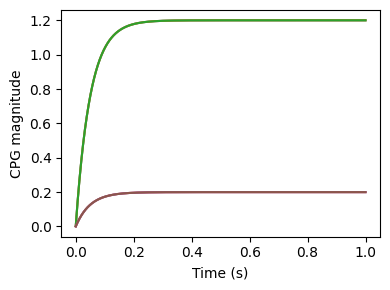

In [9]:
t = np.arange(0, run_time, nmf.timestep)
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
for ts in np.array(magnitude_hist).T:
    ax.plot(t, ts)
ax.set_xlabel("Time (s)")
ax.set_ylabel("CPG magnitude")
fig.savefig("./outputs/turning_cpg_magnitude.png")

Finally, let's take a look at the video:

In [10]:
cam.save_video("./outputs/hybrid_turning.mp4")